In [46]:
DATA_FOLDER = "../../random-data/"
OUTPUT_FOLDER = "../../injected/"
WINDOW_SIZE = 1024 # size in freq bins of injected signal

In [47]:
import setigen as stg
import blimpy as bl
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
fil_filename = 'guppi_60703_16858_008036_TIC286923464_ON_0001.0000.fil'

In [50]:
frame = stg.Frame(waterfall=DATA_FOLDER+fil_filename)

In [51]:
frame_s = frame.get_slice((l := 42_689_571), (r := l + WINDOW_SIZE))

In [52]:
signal = frame_s.add_signal(
    stg.constant_path(f_start=frame_s.get_frequency(index=200),
                      drift_rate=5*u.Hz/u.s),
    stg.constant_t_profile(level=frame.get_intensity(snr=3e3)),
    stg.gaussian_f_profile(width=100*u.Hz),
    stg.constant_bp_profile(level=1)
)

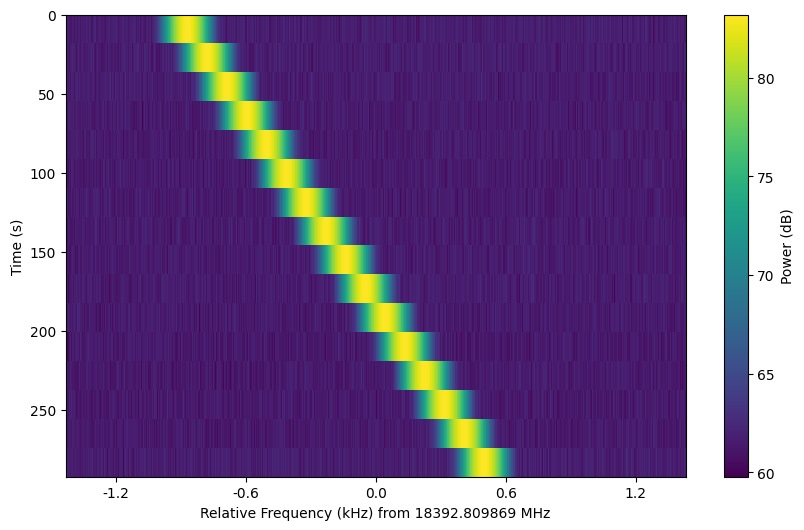

In [53]:
fig = plt.figure(figsize=(10,6))
frame_s.plot(db=True)

In [54]:
frame.data[:, l:r] = frame_s.data

In [55]:
frame.save_h5(OUTPUT_FOLDER + fil_filename[:-4] + ".mighty.h5")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../injected/guppi_60703_16858_008036_TIC286923464_ON_0001.0000.mighty.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 5.04sec


I tried running both the file with the added signal and the one without using `seticore`, and the result is the same. I could try increasing the SNR either here or in `seticore`. It would be easier with the latter, but I'm doing it from here because even if it takes longer, it will be easier to check the differences afterward.